<a href="https://colab.research.google.com/github/geoffwoollard/prob_prog/blob/main/project/pyro_1D_sigmasignal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! pip3 install pyro-ppl 

     |████████████████████████████████| 678 kB 8.0 MB/s 


In [88]:
import pyro
import torch
import matplotlib.pyplot as plt
import pyro.distributions as dist
import pandas as pd

def doplt(arr_2d): return plt.imshow(arr_2d, cmap='gray')
pyro.set_rng_seed(101)


# estimating width of atom

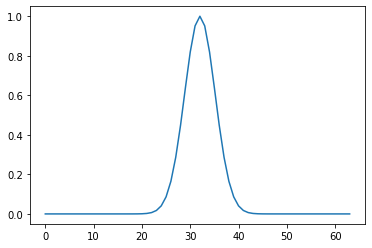

In [232]:
num_pix = 64
domain = torch.arange(-num_pix//2, num_pix//2)
sigma_signal = torch.sqrt(torch.tensor(10.))
clean_signal = torch.exp(-domain**2/(2*sigma_signal**2))
pd.Series(clean_signal).plot()

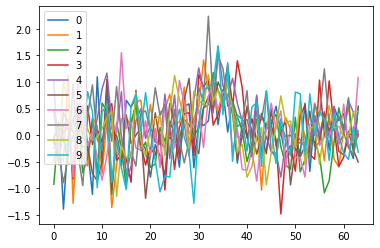

In [287]:
# synthetic data. normally, these would come from actual measurements and we would not know shift. h
# ere we have access to the ground truth
sigma_noise = 0.5
num_particles = 10000
data = torch.empty((num_particles,num_pix))
for i in range(num_particles):
  shift = 1#dist.Normal(0,2).sample()
  clean_signal = torch.exp(-(domain-shift)**2/(2*sigma_signal**2))
  data[i] = dist.Normal(clean_signal,sigma_noise).sample()
pd.DataFrame(data[:10].numpy().T).plot()

In [288]:
def model(data):
  batch_size=1
  shift = 0# pyro.sample('shift',dist.Normal(0,2))
  sigma_signal = pyro.sample('sigma_signal',dist.Normal(10,0.001))
  clean_signal = torch.exp(-(domain-shift)**2/(2*sigma_signal**2))
  with pyro.plate("data", size=len(data), subsample_size=batch_size) as ids:
    pyro.sample("particle_1d", dist.Normal(clean_signal, sigma_noise).to_event(1), obs=data[ids])

def guide(data): # the proposal distribution
  """
  learn the parameters of our modelled encoding of the signal (a 1D atom)
  hard coded fixed noise of 0.1
  """
  sigma_signal_mean = pyro.param("sigma_signal_mean", torch.tensor(10./2))
  sigma_signal_std = pyro.param("sigma_signal_std", torch.tensor(.001*20), constraint=torch.distributions.constraints.positive)
  sigma_signal = pyro.sample("sigma_signal",dist.Normal(sigma_signal_mean,sigma_signal_std))


In [290]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=model, 
                     guide=guide, 
                     optim=pyro.optim.Adam({"lr": 0.01}), 
                     loss=pyro.infer.Trace_ELBO())

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
sigma_signal_mean =  9.972959518432617
sigma_signal_std =  0.00293918838724494


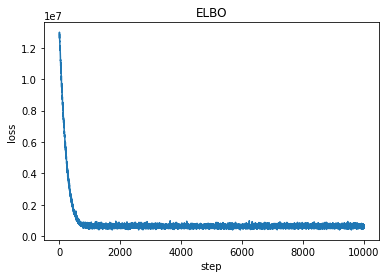

In [291]:
losses, sigma_signal_mean, sigma_signal_std  = [], [], []
num_epochs = 10000
for ep in range(num_epochs):
    if num_epochs < 10 or (ep%(num_epochs//10) == 0): print(ep)
    losses.append(svi.step(data[:]))
    sigma_signal_mean.append(pyro.param("sigma_signal_mean").item())
    sigma_signal_std.append(pyro.param("sigma_signal_std").item())

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('sigma_signal_mean = ',pyro.param("sigma_signal_mean").item())
print('sigma_signal_std = ',pyro.param("sigma_signal_std").item())

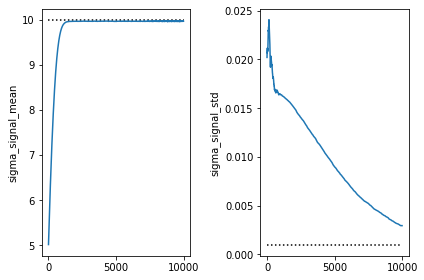

In [292]:
plt.subplot(1,2,1)
plt.plot([0,len(sigma_signal_mean)],[10,10], 'k:')
plt.plot(sigma_signal_mean)
plt.ylabel('sigma_signal_mean')
plt.subplot(1,2,2)
plt.ylabel('sigma_signal_std')
plt.plot([0,len(sigma_signal_std)],[0.001,0.001], 'k:')
plt.plot(sigma_signal_std)
plt.tight_layout() 
# std | num_particles | sigma_noise
# 0.25 | 100 | 0.1
# 0.25 | 1000 | 0.1
# 0.25 | 1000 | 0.4